# multiway CCA
This notebook contains testing code for multi-way CCA based learning using a parafac tensor decomposition in the algorithm core, rather than a SVD

In [1]:
import numpy as np
from datasets import get_dataset
from model_fitting import MultiCCA
from decodingCurveSupervised import decodingCurveSupervised
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import re
from analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load example data
dataset_loader, dataset_files, dataroot = get_dataset('plos_one')

resample by 3.0: 180->60.0Hz
EEG: X(['trial', 'time', 'channel'])(36, 504, 64) @60.0Hz
STIMULUS: Y(['trial', 'time', 'output'])(36, 504, 37)


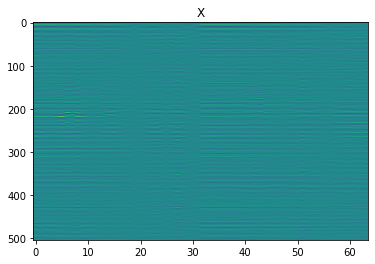

Text(0.5, 1.0, 'Y')

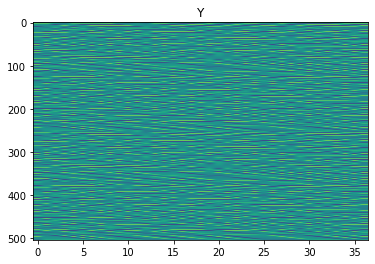

In [3]:
# load S3 -- high perf subject
subj='s3'
files = [f for f in dataset_files if re.search(subj,f)]
X,oY,coords = dataset_loader(files[-1])
fs=coords[1]['fs']
ch_names=coords[-1]['coords']
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],oY.shape))
plt.imshow(X[0,:,:],aspect='auto');plt.title('X');plt.show()
plt.imshow(oY[0,:,:],aspect='auto');plt.title('Y')

Y_true=(36, 504, 1, 2)


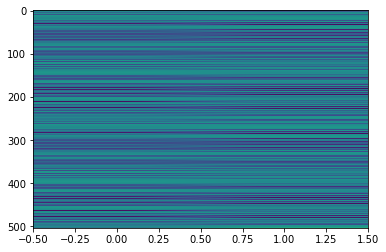

In [84]:
# get the true-label and convert to brain-response
from stim2event import stim2event
# map to event sequence, for rising/falling edges
evtlabs=('re','fe')
Y = stim2event(oY,evtypes=evtlabs,axis=-2) # (tr,samp,nY,e)
# extract the true target to fit to, using horible slicing trick
Y_true = Y[..., 0:1, :] #  (tr,samp,1,e)
print("Y_true={}".format(Y_true.shape))
plt.imshow(Y_true[0,:,0,:],aspect='auto')

Cxx=(64, 64)
Cxy=(1, 2, 39, 64)
Cyy=(1, 2, 39, 2, 39)


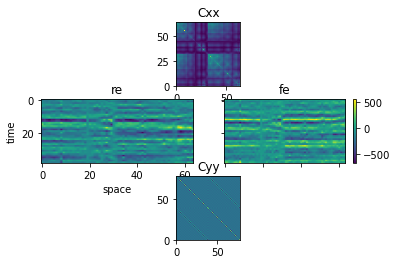

In [85]:
# get the summary statistics
from updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics
tau = 650 * fs // 1000 # ms->samples
Cxx, Cxy, Cyy = updateSummaryStatistics(X, Y_true, tau=tau)
print("Cxx={}".format(Cxx.shape))
print("Cxy={}".format(Cxy.shape))
print("Cyy={}".format(Cyy.shape))
plot_summary_statistics(Cxx, Cxy, Cyy, evtlabs=evtlabs, fs=fs, ch_names=ch_names)

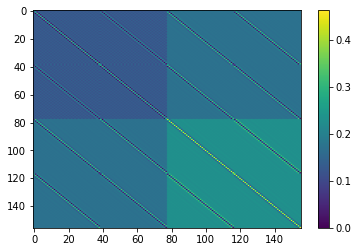

In [70]:
plt.imshow(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.colorbar()

trying to get pos from cap file!
A=(2, 64) R=(2, 2, 39)


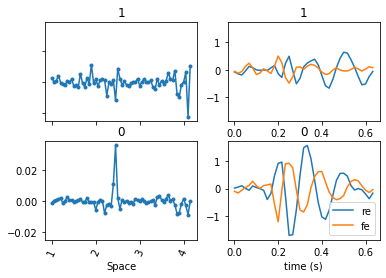

Int Lens:..............................

            IntLen    67   134   184   252   319   369   436   504 
              Perr  0.50  0.17  0.14  0.08  0.00  0.00  0.00  0.03   AUDC 17.1
         Perr(est)  0.48  0.23  0.16  0.11  0.08  0.06  0.04  0.03   PSAE 26.8
           StopErr  0.47  0.17  0.06  0.03  0.03  0.03  0.03  0.03   AUSC 14.9
     StopThresh(P)  0.46  0.24  0.09  0.05  0.05  0.05  0.05  0.05   SSAE 24.6



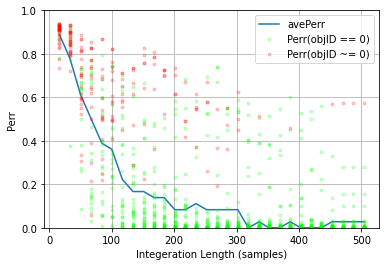

In [86]:
from multipleCCA import multipleCCA, robust_whitener
from updateSummaryStatistics import plot_factoredmodel
# run and plot the normal CCA model
J, W, R = multipleCCA(Cxx, Cxy, Cyy, reg=.02, rank=2)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()
# eval this models performance
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)

In [ ]:
# Now try with the tensor factored version..

Text(0.5, 1.0, 'Whitened: Cxx')

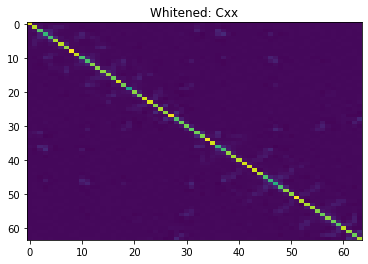

In [88]:
# 1. X spatial whitener
from multipleCCA import robust_whitener
Wx, iWx = robust_whitener(Cxx,reg=.02)

wCxxw = np.einsum("de,df,eg",Cxx,Wx,Wx)
plt.imshow(wCxxw,aspect='auto');plt.title('Whitened: Cxx')

In [89]:
# 2.Cyy combined whitener..
#  Cyy = (nM,e,tau,e,tau)
Wy, iWy = robust_whitener(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),reg=.02) # (e*tau,e*tau)
Wy = Wy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)
iWy = iWy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)

In [90]:
# 2. Y temporal whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_tau = np.sum(Cyy,axis=(0,1,3))
#plt.imshow(Cyy_tau,aspect='auto');plt.title('Cyy_tau');plt.colorbar();plt.show()
Wy_tau, iWy_tau = robust_whitener(Cyy_tau,reg=.0)

#wtauCyy_tauwtau = np.einsum("tu,tv,uw",Cyy_tau,Wy_tau,Wy_tau)
#plt.imshow(wtauCyy_tauwtau,aspect='auto');plt.title('Whitended: Cyy_tau');plt.colorbar();plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [91]:
# 2. Y event whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_e = np.sum(Cyy,axis=(0,2,4))
Wy_e, iWy_e = robust_whitener(Cyy_e,reg=.02)

#weCyy_ewe = np.einsum("ed,ef,dg",Cyy_e,Wy_e,Wy_e)
#plt.imshow(weCyy_ewe,aspect='auto');plt.title('Whitended: Cyy_tau');plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [92]:
def plotCxy(Cxy):
    for ei in range(Cxy.shape[1]):
        plt.subplot(1,Cxy.shape[1],ei+1)
        plt.imshow(Cxy[0,ei,:,:],aspect='auto')

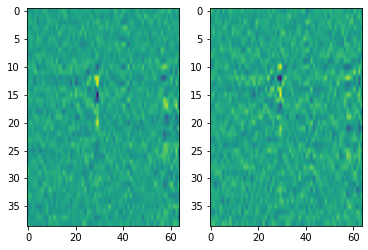

In [93]:
# apply the spatial whiteners
WxCxy = np.einsum("metd,df->metf",Cxy,Wx)
plotCxy(WxCxy)

In [94]:
# set factored/nonfactored
isFactored = True

In [95]:
# total-temporal-whitener
if not isFactored:
    WxCxyWy_t = np.einsum("metd,etgu->mgud",WxCxy,Wy)

    print("WxCxyWy {}".format(WxCxyWy_t.shape))
    plotCxy(WxCxyWy_t); plt.suptitle("Combined Temporal Whitener")

WxCxyWy (1, 2, 39, 64)


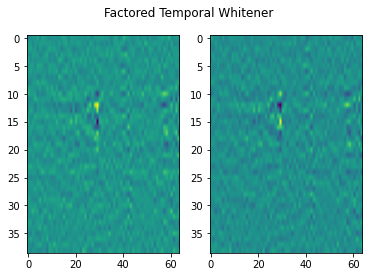

In [96]:
# factored-whitener
if isFactored:
    WxCxyWy_f = np.einsum("metd,eg,tu->mgud",WxCxy,Wy_e,Wy_tau)

    print("WxCxyWy {}".format(WxCxyWy_f.shape))
    plotCxy(WxCxyWy_f); plt.suptitle("Factored Temporal Whitener")

In [110]:
# CD/PARAFAC decomp
from tensorly.decomposition import parafac
if isFactored: 
    ten = WxCxyWy_f[0,...]
else:
    ten = WxCxyWy_t[0,...]
kruskal_decomp = parafac(ten, rank=2, normalize_factors=True)
weight = kruskal_decomp[0]
factors = kruskal_decomp[1]
We = factors[0]
Wt = factors[1]
Wd = factors[2]
print("w={}".format(weight))

# check the reconstruction error
from tensorly import kruskal_to_tensor
recons = kruskal_to_tensor(kruskal_decomp)
print('recons={}'.format(recons.shape))
normW = np.sum(np.abs(ten.ravel()))
normRecons = np.sum(np.abs(recons.ravel()))
err = np.sum(np.abs(ten.ravel()-recons.ravel()))
print('Error: |W|={} |parafac|={} |err|={}'.format(normW,normRecons,err))

w=[96.61065654 71.3266778 ]
recons=(2, 39, 64)
Error: |W|=10476.811812562528 |parafac|=4381.001773287337 |err|=8948.255614204865


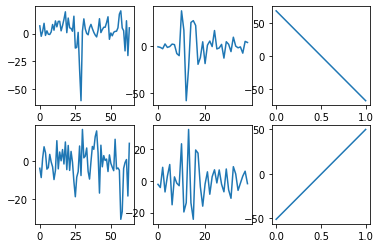

In [111]:
# plot the decomp: e,t,d x rank
rank=We.shape[1]
for r in range(rank):
    plt.subplot(rank,3,r*3+1); plt.plot(Wd[:,r]*weight[r])
    plt.subplot(rank,3,r*3+2); plt.plot(Wt[:,r]*weight[r])
    plt.subplot(rank,3,r*3+3); plt.plot(We[:,r]*weight[r])
    

trying to get pos from cap file!
A=(2, 64) R=(2, 2, 39)


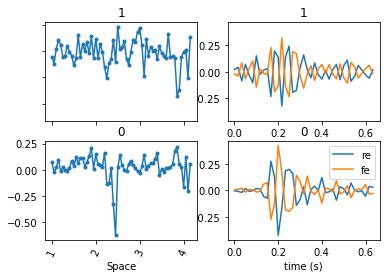

In [112]:
# make equivalent to the multiCCA outputs (so can re-use apply methods)
W = Wd.T # (rank,d)
R = np.einsum("tk,ek->ket",Wt,We) # (rank,e,tau)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()

In [113]:
# apply the spatial whitener
W = W @ iWx # (d,rank)

In [114]:
# include the temporal whitener
if isFactored:
    R = np.einsum("ket,ef,tu->kfu",R,iWy_e,iWy_tau)
else:
    R = np.einsum("ket,etfu->kfu",R,iWy)

Int Lens:..............................

            IntLen    67   134   184   252   319   369   436   504 
              Perr  0.78  0.53  0.28  0.22  0.17  0.11  0.11  0.17   AUDC 33.9
         Perr(est)  0.51  0.38  0.30  0.21  0.15  0.13  0.11  0.10   PSAE 18.8
           StopErr  0.69  0.53  0.47  0.36  0.17  0.17  0.17  0.17   AUSC 37.7
     StopThresh(P)  0.39  0.26  0.12  0.11  0.10  0.10  0.10  0.10   SSAE 47.7



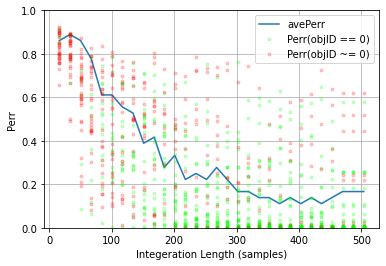

In [115]:
# apply to the data
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)